<a href="https://colab.research.google.com/github/llA-Wilsonll/Neural_Style_Transfer/blob/master/Neural_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
The goal of this project is to implement Neural Style Transfer using Tensorflow. The basic concept of Neural Style Transfer involves taking two images (your **content image** and your **style image**) and generating a new image (called the **generated image**)  which has the "content" of the content image and "style" of the style image. 

It is easier to understand the goal of Neural Style Transfer by looking at examples where people have already implemented it on a content and a style image. The below is the example used in deeplearning.ai's Deep Learning Specialization:

![NST Example](https://drive.google.com/uc?export=view&id=1FX9w-o4oR64CEueRJfP4_y_wTogl3OQQ)

# Required Libraries

I first wanted an easy way to search for, download and use some content and style images and I stumbled across the following package which allowed me to do just that:
* https://github.com/hardikvasa/google-images-download/blob/master/docs/examples.rst

In [1]:
pip install google_images_download

     |████████████████████████████████| 911kB 5.1MB/s 
  Created wheel for google-images-download: filename=google_images_download-2.8.0-py2.py3-none-any.whl size=14550 sha256=1e8e9e56a47dedd757ad839d3914db42e359b545d6d71371b8c549884d3dc41e
  Stored in directory: /root/.cache/pip/wheels/1f/28/ad/f56e7061e1d2a9a1affe2f9c649c2570cb9198dd24ede0bbab
Successfully built google-images-download


In [2]:
import numpy as np
import tensorflow as tf
import glob
import PIL.Image # so we can save the generated image
import itertools # so we can iterate over combinations of content and style images
from matplotlib.pyplot import imshow
from matplotlib.image import imread
import matplotlib.pyplot as plt
from google_images_download import google_images_download   #importing the library
from keras.applications.vgg19 import VGG19
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg19 import preprocess_input

Using TensorFlow backend.


# How Tensorflow optimises Variables

## What is Neural Style Transfer Optimising

One key difference that neural style transfer has over other more traditional projects I have worked with is the fact that the "weights" that are being updated at each iteration of training are the pixel values of the generated image. As we will soon see, the content, style and generated images are each passed through a VGG19 model and the activations of certain layers are compared between the cost-generated images and the style-generated images. Therefore, initially I was a little confused as to how Tensorflow would be updating one of the "input" images as opposed to updating the weights of a model.


## Demonstraing Tensorflow Optimisation

Therefore, before diving head first into this project, I used the following example to test how the Tensorflow optimizers are minimising their provided loss functions. 

We are testing the case where we have a constant output ($Y=7$) and a costant function ($2\times X+1$) and seeing how tensorflow optimises the variable X:


*   Inputs: the 2 and the 1 in the function [ $2 \times X + 1$]?
*   Predicted value: $\hat{Y}=2\times X + 1$
*   Label (true value): $Y=7$, this is a placeholder
*   Weights: $X$ this is a variable.

We have a simple loss function:
$$\text{loss}=(Y - \hat{Y})^2$$

The goal is to update the variable $X$ such that our predicted value $\hat{Y}$ gets closer to the true value $Y=7$. This is done by optimising our loss function. 



In [3]:
tf.reset_default_graph()

# Placeholder for the true label
Y = tf.placeholder(tf.float32, [1], name='labels')

# Variable which will hold our "weights". Initialising it to 10.0
X = tf.Variable(10.0, name='weights')

# The predicted label, defined by some operation on the "weights" X
Y_hat = 2*X + 1

# The loss we will optimise, defined on the true and predicted labels
# and therefore defined as a function of the "weights" X
loss = tf.math.square(Y - Y_hat)

# Learning rate hyperparameter for gradient descent
learning_rate = 0.01
# Optimising the loss function using gradient descent
train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

# Required to initialise the tf variables
init_op = tf.global_variables_initializer()

with tf.Session() as test_sess:
    writer = tf.summary.FileWriter("./logs",test_sess.graph)
    # ***initialization of all variables... NOTE this must be done before running any further sessions!***
    test_sess.run(init_op)
    
    for i in range(101):

      # This piece of code is what updates the weights variable X
      test_sess.run(train_step, feed_dict={Y: [7]})
      
      # Printing the value of X every 20 iterations
      if i%20 == 0:
        print('Iterartion ' + str(i) + ' X = ' + str(X.eval()))
        
    X_final = X
    print(X_final.eval())

    writer.close()


Iterartion 0 X = 9.44
Iterartion 20 X = 4.215185
Iterartion 40 X = 3.2292976
Iterartion 60 X = 3.0432668
Iterartion 80 X = 3.008164
Iterartion 100 X = 3.0015404
3.0015404


As you can see, at each iteration Tensorflow optimises the loss function by updating the variables that are used in calculation which makes up the loss function, in this case $X$. \\

This example will be somewhat analogous to what we will do in Neural style transfer. 
*   Inputs: constant values which don't change, analogous to the content and style image pixel values.
*   Prediction: the activations of the generated image for certain layers. This will be some combination of operations on the weights (generated image in this case).
*   Labels: the activations of the content and style images for certain layers. We have a constant label we are trying to optimise towards.
*   Weights: the generated image pixel values. This will be a variable. 

The loss function is defined using the activations of the content, style and generated images. Thus, as long as we insure that **the loss function is defined as some operation on the generated image variable**, then as the only variable being used in the loss function is the generated image then each time we optimise the loss function this should be what is updated.

##Tensorboard
In the above example you can see we used `tf.summary.FileWriter`. This created an events file which has the information of the current computational graph. The steps I used to display the computational graph in Tensorboard are:
1. Downloading the events file and saving it locally in a folder called log.
2. Open a terminal (I used Anaconda Prompt) and cd to the location that contains the log folder.
3. Run the following command: 
> `tensorboard --logdir=log --host localhost --port 8088`
4. Copy the http path that is given in the terminal and paste into a browser.

Below is the computational graph that was produced:

![NST Example](https://drive.google.com/uc?export=view&id=1WIf2bQ1PEEgFPQfdsHFpcBdc-_94qrfA)

# Downloading the Data

We will use the package we installed earlier to download some content and style images through a google images search. 

## Downloading the Content Images
The content images are downloaded with the following parameters specified: 
* Downloading 5 images of "Hopping Kangaroos"
* Only choosing images with dimension 400*300
  * Reason being is that we don't want to have to distort the dimensions of the content image.
* Storing images in the directory content/images/content/

In [4]:
response = google_images_download.googleimagesdownload()   #class instantiation


arguments_content = {"keywords":"Hopping Kangaroos",
                     "limit":5,
                     "exact_size":"400,300",
                     "output_directory":"images",
                     "image_directory":"content",
                     "print_urls":True}   #creating list of arguments
paths_C = response.download(arguments_content)   #passing the arguments to the function


Item no.: 1 --> Item name = Hopping Kangaroos
Evaluating...
Starting Download...
Image URL: https://i.pinimg.com/originals/30/ee/59/30ee59af1ee4f744b89d772b641c25d5.jpg
Completed Image ====> 1.30ee59af1ee4f744b89d772b641c25d5.jpg
Image URL: https://bloximages.newyork1.vip.townnews.com/stltoday.com/content/tncms/assets/v3/editorial/b/96/b9650dac-697b-5d5f-b02e-00499e406525/56980ab09568b.image.jpg?resize=400%2C300
Completed Image ====> 2.56980ab09568b.image.jpg
Image URL: http://2.bp.blogspot.com/-E_37EJZxWpc/UkqcGVGJq2I/AAAAAAAALNI/jweaNSh5phY/s400/Hopping+Kangaroos.jpg
Completed Image ====> 3.Hopping+Kangaroos.jpg
Image URL: http://www.thegreynomads.com.au/wp-content/uploads/2015/09/kangaroos1a.gif
Completed Image ====> 4.kangaroos1a.gif
Image URL: http://www.thegreynomads.com.au/wp-content/uploads/2018/05/roo.jpg
Completed Image ====> 5.roo.jpg

Errors: 0



## Downloading the Style Images
The style images are downloaded with the following parameters specified
* Downloading 10 "Aboriginal Artwork" images
* Only choosing images with dimension greater than 400*300
  * We can augment the images to have dimensions 400*300 and the "style" of the images should still be the same
* Storing images in the directory content/images/style/

In [5]:
arguments_style = {"keywords":"Aboriginal Artwork",
                   "limit":5,
                   "size":">400*300",
                   "output_directory":"images",
                   "image_directory":"style",
                   "print_urls":True}   #creating list of arguments
paths_S = response.download(arguments_style)   #passing the arguments to the functionw


Item no.: 1 --> Item name = Aboriginal Artwork
Evaluating...
Starting Download...
Image URL: https://img.theculturetrip.com/768x432/wp-content/uploads/2018/05/aboriginal-artwork--barbara-dieu-flickr-1.jpg
Completed Image ====> 1.aboriginal-artwork--barbara-dieu-flickr-1.jpg
Image URL: https://japingkaaboriginalart.com/wp-content/uploads/bb-plugin/cache/Jap-012903-Walangkura-1024x675-landscape.jpg
Completed Image ====> 2.Jap-012903-Walangkura-1024x675-landscape.jpg
Image URL: https://www.kateowengallery.com/image.axd?picture=2016%2F10%2FMEPU13351.png
Invalid or missing image format. Skipping...
Image URL: https://www.snswlhd.health.nsw.gov.au/getmedia/03f04278-8fbd-4003-84e8-d1f2e6106e2c/Alison-Simpson-Artwork
Invalid or missing image format. Skipping...
Image URL: https://d36lty2xa4smx3.cloudfront.net/product-images/b_92.jpg
Completed Image ====> 3.b_92.jpg
Image URL: https://bluethumb.com.au/blog/wp-content/uploads/2019/04/michelle-wilura-kickett-noorn-boodjah-snake-country-bluethumb

# Overview of steps for generating the Generated Image

At a high level, the steps required to take a content and a style image and create the generated image are to:
1.   Take the content and style images and subtract the mean R, G & B values from when VGG19 was trained on ImageNet (use `preprocess_input`).
2.   Create an "iteration 0" generated image.
3.   Define the Style Cost and Content Cost functions using the activations of certain layers of the VGG19 model, and then combine to form the final cost function J.
4.   Optimize J.
5.   After optimizing, reshape the output generated image (add back the mean RGB values).


# Image Preprocessing

Now we have downloaded our images, we need to preprocess them so they are in a form in which we can use in our model. This is done through creating a function which has the following steps:

1. Loading the style images and reshaping them.
2. Then converting the pixels to an array.
3. Reshapping to have the first dimension be the "number of samples".
4. Subtracting channel means (done through the `preprocess_input` function from `keras.applications.vgg19`).
5. Storing the images into a dictionary of images.


In [0]:
def prepare_images(image_path,image_names):
  images_dict = {}
  
  for index, name in enumerate(image_names):
    # load the image
    image = load_img(image_path + name, target_size=(300, 400))

    # convert pixels into numpy array
    image = img_to_array(image)

    # Add "samples" dimension to array, as this is what the network is expecting as input
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

    # VGG input images need to have the same mean RGB values subtracted as was used for imagenet: RGB [123.68, 116.779, 103.939]
    image = preprocess_input(image)

    # Store preprocessed images into a dictionary
    images_dict["image{0}".format(index)] = image
  
  return images_dict

Preprocessing the style images:

In [0]:
# Preprocess Style Images
style_image_path = "/content/images/style/"
style_image_names = glob.glob1(style_image_path,"*.jpg")

style_images_dict = prepare_images(style_image_path,style_image_names)

Preprocessing the content images:

In [0]:
# Preprocess Content Images
content_image_path = "/content/images/content/"
content_image_names = glob.glob1(content_image_path,"*.jpg")

content_images_dict = prepare_images(content_image_path,content_image_names)

Testing the shape of the content and style images after preprocessing. 

In [9]:
print(style_images_dict['image0'].shape)
print(content_images_dict['image0'].shape)

(1, 300, 400, 3)
(1, 300, 400, 3)


## Post-processing Function

We will set up our post processing function so that once the generated image is "generated", we can apply the necessary post processing and save it.

If desired, this function could be called every dozen or so iterations to see how the image generation is progressing.

In [0]:
def output_and_save_image(image, save_path, save_name):
  # Combining the save path and name
  file_name = save_path + save_name + '.png'
  
  # This is for BGR channels
  image = image.reshape(300,400,3) + np.array([103.939, 116.779,123.68]).reshape((1,1,3))
  
  # Limiting the min value to 0 and max value to 255 (maybe need to call image[0])
  image = np.clip(image, 0, 255).astype('uint8')
  
  # Have to reorder channels to from RGB to BGR
  image = image[...,::-1]
  
  # Write the image-file in jpeg-format.
  with open(file_name, 'wb') as file:
      PIL.Image.fromarray(image).save(file)
  
  # Showing the image
  imshow(image)

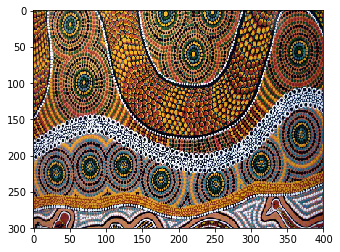

In [11]:
# Saving all the content and style images as PNG with new names
for cont_image in list(content_images_dict):
  output_and_save_image(content_images_dict[cont_image],"/content/images/","content_"+cont_image)

for sty_image in list(style_images_dict):
  output_and_save_image(style_images_dict[sty_image],"/content/images/","style_"+sty_image)

# Create Iteration 0 Generated Image

Initialize generated image to be a nosiy image which is created from the content image.

In [0]:
def generate_noise_image(content_image, noise_ratio = 0.6):
    
    # Generate a random noise_image
    noise_image = np.random.uniform(-20, 20, (1, 300, 400, 3)).astype('float32')
    
    # Set the input_image to be a weighted average of the content_image and a noise_image
    input_image = noise_image * noise_ratio + content_image * (1 - noise_ratio)
    
    return input_image

In [0]:
def generate_noise_image_dict(images_dict,image_names):
  generated_images_dict = {}
  
  # Iterate over content images
  for index, name in enumerate(image_names):
    generated_images_dict["image{0}".format(index)] = generate_noise_image(images_dict["image{0}".format(index)])
    
  return generated_images_dict

Generating the inital "generated" image for each content image in `content_images_dict`

In [0]:
generated_images_dict = generate_noise_image_dict(content_images_dict,content_image_names)

In [15]:
print(content_images_dict.keys())
print(generated_images_dict.keys())

dict_keys(['image0', 'image1', 'image2', 'image3'])
dict_keys(['image0', 'image1', 'image2', 'image3'])


Test that it worked for the images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


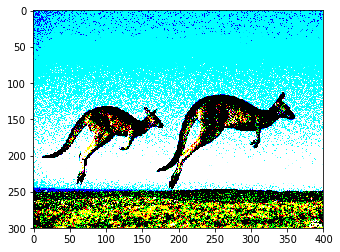

In [16]:
# Reording Channels to RGB so that they are in the correct order for imshow
generated_image_test = generated_images_dict['image0'][...,::-1]
imshow(generated_image_test[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


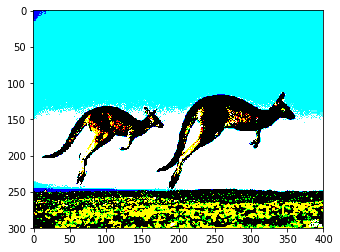

In [17]:
content_image_test = content_images_dict['image0'][...,::-1]
imshow(content_image_test[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


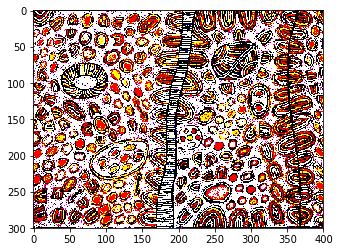

In [18]:
style_image_test = style_images_dict['image0'][...,::-1]
imshow(style_image_test[0])

Note that the colours of the images displayed above are off because these are of the images after they have been preprocessed (mean RGB values have been subtracted).

# Defining our Model

The model we will use will be VGG19 pretrained on the ImageNet data. However, when we pass our content, style and generated images through the VGG19 model, we only need the activations of certain layers which the content and style cost functions will be defined on.Thus, we define our own model to represent this. 

## Code to Get Layer Activations

The following function builds a VGG19 model that returns a list of intermediate layer outputs. The following TensorFlow tutorial was very useful in helping to define this:
https://www.tensorflow.org/beta/tutorials/generative/style_transfer

Note that we specify the following parameters when calling `tf.keras.applications.VGG19`:
* `include_Top=False` - don't include the 3 fully-connected layers at the end of the network
* `input_shape=(300,400,3)` - input image shape
* `weights='imagenet'` - get pre-trained weights trained on ImageNet

In [0]:
def define_model(content_layers, style_layers):
  """ 
  Creates a vgg model that returns a list of intermediate output values.
  
  Arguments:
      - content_layers: python list of layers you want to use when calculating
                        the content cost. 
                        e.g.LAYERS = ['block1_conv1', 'block2_conv1'] 
                        
      - style_layers: python list of layers you want to use when calculating
                      the style cost.                  
  """
  
  # Loading the VGG19 model pretrained on imagenet data
  VGG19_model = tf.keras.applications.VGG19(include_top=False, weights='imagenet',input_shape=(300,400,3))
  VGG19_model.trainable = False
  
  content_outputs = [VGG19_model.get_layer(name).output for name in content_layers]
  style_outputs = [VGG19_model.get_layer(name).output for name in style_layers]
  
  model_outputs = content_outputs + style_outputs

  model = tf.keras.Model(VGG19_model.input, model_outputs)
  return model

We will later define a model with the above definition in the same session we call these functions.

> LEARNING: Remeber to run things in a seesion (and the correct one at that). Initially I had a problem which WAS THE STYLE_EXTRACTOR and STYLE_OUTPUTS WEREN'T IN THE SESSION: https://github.com/tensorflow/tensorflow/issues/28287

The following function is created so that we can feed an image into our VGG19 model and get the activations for the provided layer names.

In [0]:
def get_activations(model, image, content_layers, style_layers):
  """
  Arguments:
      - model: the model which is defined by the define_model function
  
      - image:  tensor of the image you want to feed into the model. 
                has shape (1,300,400,3)
                
      - content_layers: python list of layers you want to use when calculating
                        the content cost. 
                        e.g.LAYERS = ['block1_conv1', 'block2_conv1'] 
                        
      - style_layers: python list of layers you want to use when calculating
                      the style cost. 
  """
  
  model_outputs = model(image)
  content_activations = [layer[0] for layer in model_outputs[:len(content_layers)]]
  style_activations = [layer[0] for layer in model_outputs[len(content_layers):]]
  return content_activations, style_activations

Storing the Tensors of the activations for given layers into a python dictionary. \\
May no longer need below code.

In [0]:
def get_activations_dictionary(layer_names, activations):
  """
  Arguments:       
      - layer_names: python list of layers you want to get activations for.
                     e.g.LAYERS = ['block1_conv1', 'block2_conv1'] 
                     
      - activations: Tensor of activations for the provided layer_names
      
  Returns:
      - activations_tensor_dict: dictionary of tensors for the given layers
      - activations_array_dict: dictionary of arrays for the given layers
  """
  
  activations_tensor_dict = {}
  
  if len(layer_names) == 1:
    activations_tensor_dict[layer_names[0]] = activations[0]
  else:
    for name, output in zip(layer_names, activations):
      activations_tensor_dict[name] = output
  
  return activations_tensor_dict

Defining the layers we want to use to measure the style:

In [0]:
STYLE_LAYERS = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1'
               ]

Defining the layers we want to use to measure the content:

In [0]:
CONTENT_LAYERS = ['block5_conv2']

# Cost Function


## Define Content Cost Function

The content cost function measures how similar the "content" of the generated image is to the "content" of the content image. It does this by doing an element-wise comparison of the activations of a hidden layer somewhere in the middle of the model. 

The Content Cost function we have defined in the below function is:
$$J_{content}(C,G) = \frac{1}{4n_Hn_Wn_C}||a^{[l](C)}-a^{[l](G)}||^2$$

where:
* $n_H$, $n_W$ and $n_C$ are the height, width and channel depth of the current layer.
* $a^{[l](C)}$ and $a^{[l](G)}$ represent the activations of the content image and generated image at the current layer $l$. 

In [0]:
def content_cost(content_activations,generated_activations):
  """
  Arguments:
      - content_activations:  activations of the content image calculated 
                              for specific layers
      - generated_activations:  activations of the generated image calculated 
                                for the same specific layers                              
  """
  
  n_H, n_W, n_C = generated_activations.get_shape().as_list()

  # Compute the content cost
  J_content = (1/(4*n_H*n_W*n_C))*tf.reduce_sum(tf.square(tf.subtract(content_activations,generated_activations)))

  return J_content

Future edit: I may want to define the *content* cost function so that it can be done over multiple layers as will be done for the style cost function.

TEST: Expect to get 6.76559.

In [25]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    a_C = tf.random_normal([4, 4, 3], mean=1, stddev=4)
    a_G = tf.random_normal([4, 4, 3], mean=1, stddev=4)
    J_content = content_cost(a_C, a_G)
    print("J_content = " + str(J_content.eval()))

J_content = 6.7655935


## Define Style Cost Function

The style cost function measures how similar the "style" of the generated image is to the "style" of the style image. It does this by using the activations of a particular layer and looking at how correlated the activations are through the different channels. Thus, this will give you a style matrix (Gram matrix) of shape $n_c^{[l]}\times n_c^{[l]}$. To populate the Gram matrix for activations of a given layer, you look at the entries for each channel pair (k,k’) with:
$$G_{kk'}=\sum_{i=1}^{n_H}\sum_{j=1}^{n_W}a_{ijk}\cdot a_{ijk'}$$ 
Therefore, it is clear how the Gram matrix has shape $n_c^{[l]}\times n_c^{[l]}$. 

The Style Cost function is then defined by doing an element-wise comparison of the Gram matrix of the style and generated images:
$$J_{style}(S,G) = \frac{1}{(2n_Hn_Wn_C)^2}||G^{(S)}-G^{(G)}||^2$$  

Defining the Gram matrix so we can compare the correlation between filters:

In [0]:
def gram_matrix(input_matrix):
  """
  Arguments:
      - input_matrix:  tensor with 2 dimensions (a matrix)                             
  """ 
  
  gram_matrix = tf.matmul(input_matrix,tf.transpose(input_matrix))
  
  return gram_matrix

Define the style cost for a given layer:

In [0]:
def style_layer_cost(style_activations,generated_activations):
  """
  Arguments:
      - style_activations:  a tensor of activations of the style image for a 
                            given layer
      - generated_activations:  a tensor of activations of the generated image 
                                for a the same given layer
  """ 
  # Get the height, width and number of channels 
  height, width, channels = generated_activations.get_shape().as_list()

  # Reshape the images to have them of shape (channels, height*width)
  style_activations = tf.transpose(tf.reshape(style_activations,[height*width,channels]))
  generated_activations = tf.transpose(tf.reshape(generated_activations,[height*width,channels]))

  # Computing gram_matrices for both the style and generated images
  gram_style = gram_matrix(style_activations)
  gram_generated = gram_matrix(generated_activations)

  J_style_layer = (1/((2*channels*height*width)**2))*tf.reduce_sum(tf.square(tf.subtract(gram_style,gram_generated)))

  return J_style_layer

> Note: the function takes tensors as input. Thus,  these tensors need to be defined in the same session as when I am calling them (feeding them into this `style_layer_cost` function), rather then calculating them in a earlier session.

TEST: Expect to get 9.19028

In [28]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    a_S = tf.random_normal([4, 4, 3], mean=1, stddev=4)
    a_G = tf.random_normal([4, 4, 3], mean=1, stddev=4)
    J_style_layer = style_layer_cost(a_S, a_G)
    
    print("J_style_layer = " + str(J_style_layer.eval()))

J_style_layer = 9.190279


Defining the total style cost which sums the output of the `style_layer_cost` function for the layers you specify:

In [0]:
def style_cost(style_activations,generated_activations,layer_names):
  """
  Arguments:
      - style_activations_dict: a dictionary of activations for the style image 
                                in the form of tensors for given layers 
      - generated_activations_dict: a dictionary of activations for the 
                                    generated image in the form of tensors 
                                    for the same given layers 
      - layer_names: the layers which we will use to define the style
  """ 
  # initialise style cost
  J_style = 0.0
  
  # coefficient to scale between layers. Ideally we would have this as an input
  coeff = 1 / len(layer_names)
  
  #for layer_name in layer_names: 
  for name, a_C, a_G in zip(layer_names, style_activations, generated_activations):
    J_style_layer = style_layer_cost(a_C, a_G)
    J_style += coeff * J_style_layer
    
  return J_style

## Total Cost Function
The total cost function is just a linear combination of the content and style cost functions. \\
Need to give alpha and beta initial values so that the function can be run without needing to specify them

In [0]:
def total_cost(J_content, J_style, alpha = 10, beta = 40):
  """
  Arguments:
      - J_content: the content cost 
      - J_style: the style cost
      - alpha: value with which to scale the content cost
      - beta: value with which to scale the style cost
  """  
  
  J_total = alpha * J_content + beta * J_style
  
  return J_total

# Generating our Image

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
80142336/80134624 [==============================] - 1s 0us/step
Iterartion 0
Iteration 0 :
total cost = 9611.946
content cost = 0.0014324915
style cost = 240.29828
Iterartion 50
Iteration 50 :
total cost = 415.3425
content cost = 0.0009802927
style cost = 10.383318
Iterartion 100
Iteration 100 :
total cost = 63.27627
content cost = 0.0011925802
style cost = 1.5816087
Iterartion 150
Iteration 150 :
total cost = 21.620214
content cost = 0.0012380354
style cost = 0.5401958
Iterartion 200
Iteration 200 :
total cost = 11.66605
content cost = 0.001245627
style cost = 0.29133984
Iterartion 250
Iteration 250 :
total cost = 7.6425366
content cost = 0.0012476587
style cost = 0.19075151
Iterartion 300
Iteration 300 :
total cost = 5.556398
content cost = 0.0012474706
style cost = 0.13859808
Iterartion 350
Iteration 350 :
total cost = 4.3078074
content cost = 0.0012479356
style cost = 0.10738321
Iterartion 400
Iterati

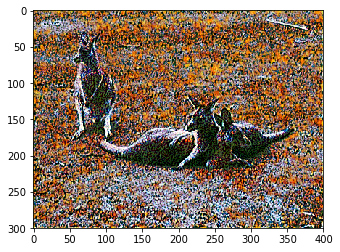

In [31]:
# Iterating over the images in our content and style dictionaries
for content_image_number, style_image_number in list(itertools.product(content_images_dict,style_images_dict)):

  # Reset the graph
  tf.reset_default_graph()

  with tf.Session() as sess:

    # Create initial generated image  
    image = tf.get_variable("image",initializer=tf.convert_to_tensor(generated_images_dict[content_image_number], dtype=tf.float32))

    # Load our model which uses the pretrained VGG19, trained on imagenet data
    # and only outputs the activations for the provided content and style layers
    model = define_model(CONTENT_LAYERS, STYLE_LAYERS)

    # Activations from style image required to calculate Style Cost
    style_image = tf.convert_to_tensor(style_images_dict[style_image_number])
    style_c_outputs, style_s_outputs = get_activations(model, style_image, CONTENT_LAYERS, STYLE_LAYERS)
    sess.run(style_s_outputs)
    style_activations_tensor_dict = get_activations_dictionary(STYLE_LAYERS, style_s_outputs)

    # Activations from content image required to calculate Content Cost
    content_image = tf.convert_to_tensor(content_images_dict[content_image_number])
    content_c_outputs, content_s_outputs = get_activations(model, content_image, CONTENT_LAYERS, STYLE_LAYERS)
    sess.run(content_c_outputs)
    content_activations_tensor_dict = get_activations_dictionary(CONTENT_LAYERS,content_c_outputs)

    # Feed image variable to the model so we can get the activations
    model_outputs = model(image)

    # Splitting the outputs into content and style outputs
    generated_c_outputs = [layer[0] for layer in model_outputs[:len(CONTENT_LAYERS)]]
    generated_s_outputs = [layer[0] for layer in model_outputs[len(CONTENT_LAYERS):]]
    generated_c_activations_tensor_dict = get_activations_dictionary(CONTENT_LAYERS,generated_c_outputs)
    generated_s_activations_tensor_dict = get_activations_dictionary(STYLE_LAYERS,generated_s_outputs)

    # Calculating the loss function
    with tf.name_scope('J_content'):
      J_content = content_cost(content_activations_tensor_dict['block5_conv2'],generated_c_activations_tensor_dict['block5_conv2'])
    with tf.name_scope('J_style'):
      J_style = style_cost(style_s_outputs,generated_s_outputs,STYLE_LAYERS)
    with tf.name_scope('J_total'):
      J_total = total_cost(J_content, J_style)

    # Define the optimiser
    optimizer = tf.train.AdamOptimizer(learning_rate=2.0)

    # Specifying to apply the optimiser to minise the loss J_total
    train_step = optimizer.minimize(loss = J_total, var_list = image)

    # Required to initialise the tf variables
    init_op = tf.global_variables_initializer()

    writer = tf.summary.FileWriter("./logs",sess.graph)

    # ***initialization of all variables... NOTE this must be done before running any further sessions!***
    sess.run(init_op)

    sess.run(model(image))

    for i in range(500):

      # This piece of code is what updates the weights variable X
      sess.run(train_step)

      # Printing the value of image every 50 iterations
      if i%50 == 0:
        print('Iterartion ' + str(i))
        Jt, Jc, Js = sess.run([J_total, J_content, J_style])
        print("Iteration " + str(i) + " :")
        print("total cost = " + str(Jt))
        print("content cost = " + str(Jc))
        print("style cost = " + str(Js))

      sess.run(model(image))

    gen = image
    output_and_save_image(gen.eval(),"/content/images/","gen_Content"+content_image_number+"_Style"+style_image_number)

  writer.close()

  

# Results
As a recap, we will display the content and style images we downloaded, along with their corresponding generated images.

## Content Image Inputs

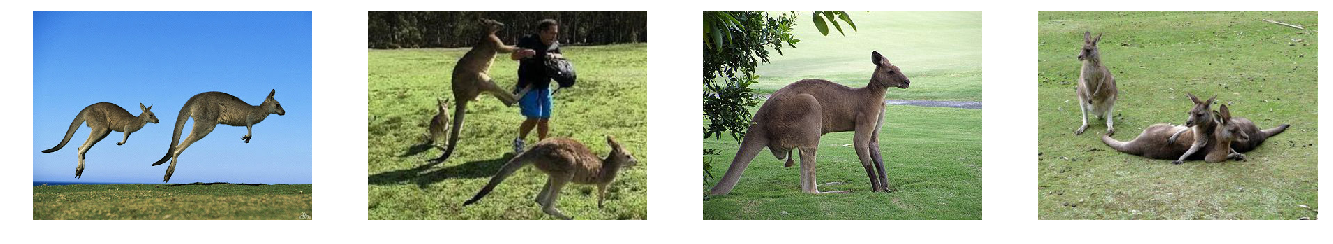

In [32]:
fig_c = plt.figure(figsize = (23,6))
n = len(content_images_dict)
for i, cont_image in enumerate(list(content_images_dict)):
  a = fig_c.add_subplot(1,n,i+1)
  imgplot = imshow(imread('/content/images/content_'+cont_image+'.png'))
  plt.axis('off')

## Style Image Inputs

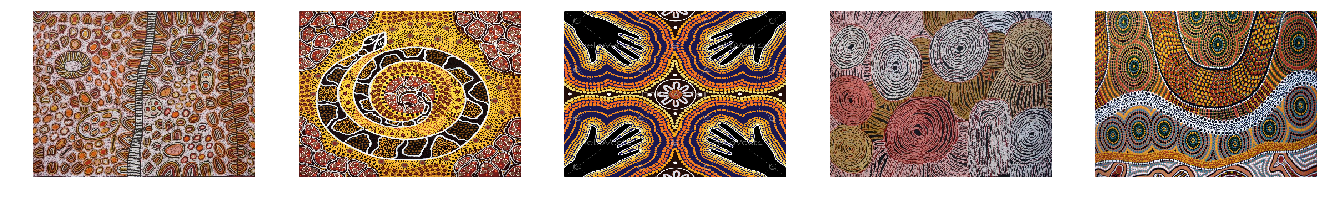

In [33]:
fig_s = plt.figure(figsize = (23,6))
m = len(style_images_dict)
for i, styl_image in enumerate(list(style_images_dict)):
  a = fig_s.add_subplot(1,m,i+1)
  imgplot = imshow(imread('/content/images/style_'+styl_image+'.png'))
  plt.axis('off')

## Resulting Generated Images

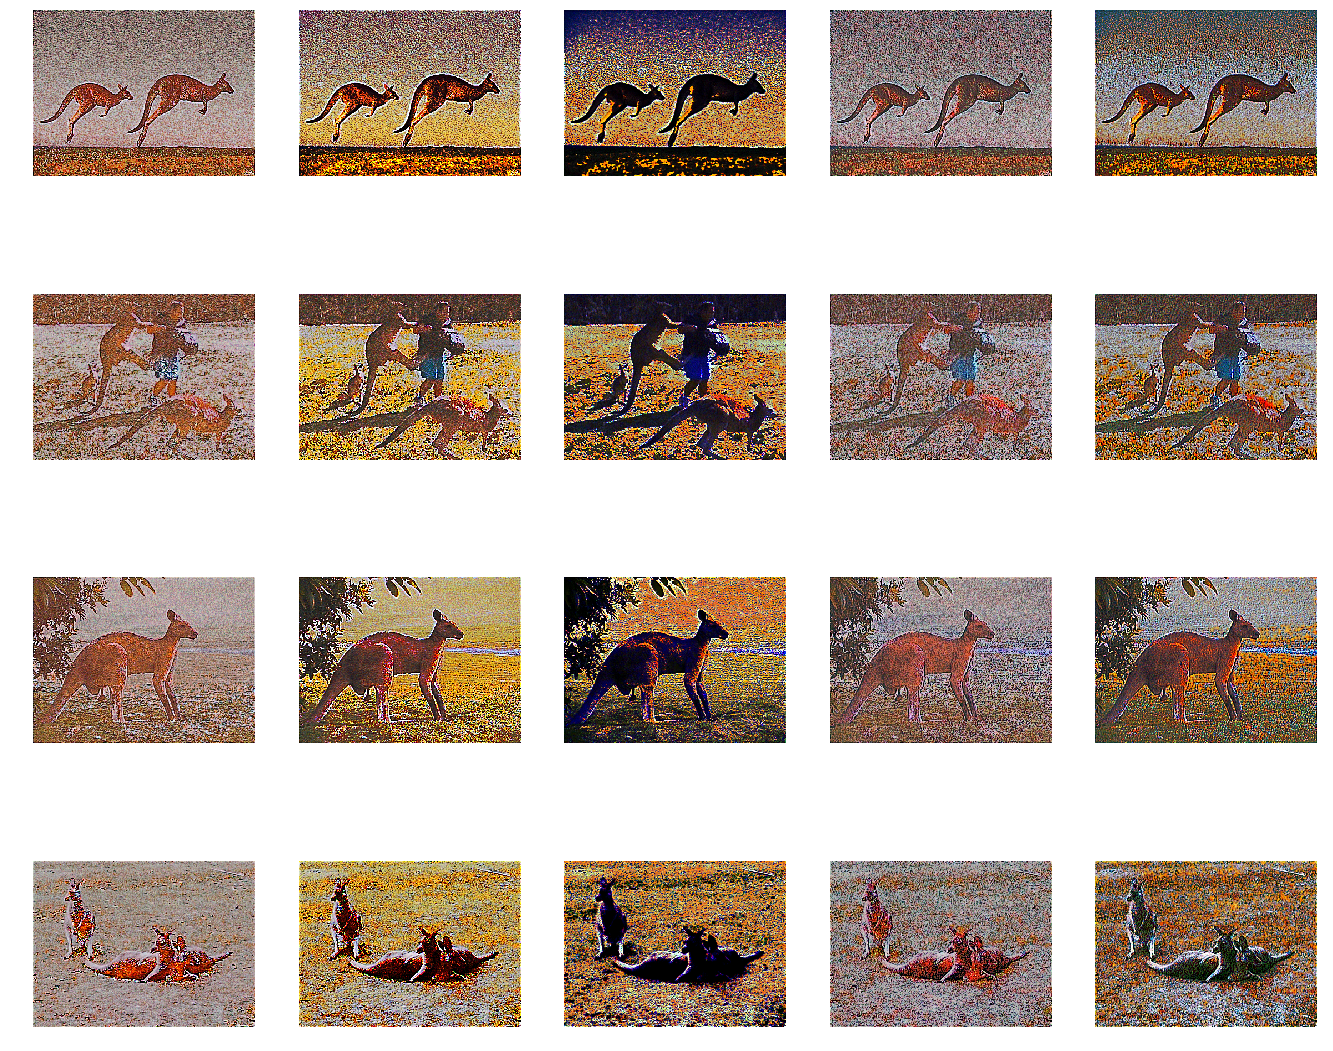

In [38]:
fig_g = plt.figure(figsize = (23,20))

i = 1
for content_image_number in list(content_images_dict):
  for style_image_number in list(style_images_dict):
    a = fig_g.add_subplot(n,m,i)
    imgplot = imshow(imread('/content/images/gen_Content'+content_image_number+'_Style'+style_image_number+'.png'))
    plt.axis('off')
    i += 1